In [4]:
import torch
from torch import nn
import dltools

In [45]:
def masked_softmax(X,valild_lens):
    if valild_lens is None:
        return nn.functional.softmax(X,dim=1)
    else:
        shape = X.shape
        if valild_lens.dim() == 1:
            valid_lens = torch.repeat_interleave(valild_lens,shape[1])
        else:
            valid_lens = valid_lens.reshape(-1)
        dltools.sequence_mask(X.reshape(-1,shape[-1]),valid_lens,value=-1e6)
        return nn.functional.softmax(X.reshape(shape),dim=-1)

In [18]:
a = torch.rand(2,3,4)


In [ ]:
print(masked_softmax(a,torch.tensor([2,3])))

In [21]:
import torch

a = torch.arange(4)        # [0, 1, 2, 3]
b = torch.ones((2, 4))     # [[1,1,1,1],[1,1,1,1]]

print(a.shape)  # torch.Size([4])
print(b.shape)  # torch.Size([2,4])

# 自动广播：a 被扩展到 [2,4]
print(a + b)


torch.Size([4])
torch.Size([2, 4])
tensor([[1., 2., 3., 4.],
        [1., 2., 3., 4.]])


In [50]:
class AdditiveAttention(nn.Module):
    def __init__(self, key_size,query_size,num_hiddens,dropout,**kwargs):
        super().__init__(**kwargs)
        self.W_k = nn.Linear(key_size,num_hiddens,bias=False)
        self.W_q = nn.Linear(query_size,num_hiddens,bias=False)
        self.W_v = nn.Linear(num_hiddens,1,bias=False)
        self.dropout = nn.Dropout(dropout)
    def forward(self,queries,keys,values,valid_lens):
        print(queries.shape,keys.shape,values.shape)
        queries,keys = self.W_q(queries),self.W_k(keys)
        print(queries.shape,keys.shape,values.shape)
        features = queries.unsqueeze(2) + keys.unsqueeze(1)
        print(features.shape)
        features = torch.tanh(features)
        print(features.shape)
        score = self.W_v(features).squeeze(-1)   # ✅ 注意这里

        self.attention_weight = masked_softmax(score,valid_lens)
        return torch.bmm(self.dropout(self.attention_weight),values)

In [51]:
queries,keys = torch.normal(0,1,(2,1,20)),torch.ones((2,10,2))
values = torch.arange(40,dtype=torch.float32).reshape(1,10,4).repeat(2,1,1)
valid_lens = torch.tensor([2,6])
attention = AdditiveAttention(key_size=2,query_size=20,num_hiddens=8,dropout=0.1)
attention.eval()
attention(queries,keys,values,valid_lens)

torch.Size([2, 1, 20]) torch.Size([2, 10, 2]) torch.Size([2, 10, 4])
torch.Size([2, 1, 8]) torch.Size([2, 10, 8]) torch.Size([2, 10, 4])
torch.Size([2, 1, 10, 8])
torch.Size([2, 1, 10, 8])


tensor([[[ 2.0000,  3.0000,  4.0000,  5.0000]],

        [[10.0000, 11.0000, 12.0000, 13.0000]]], grad_fn=<BmmBackward0>)

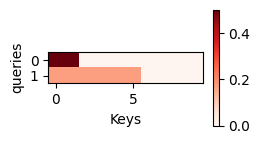

In [52]:
dltools.show_heatmaps(attention.attention_weight.reshape((1,1,2,10)),xlabel='Keys',ylabel='queries')

In [53]:
import math


class DotRroductAttention(nn.Module):
    def __init__(self, dropout, **kwargs):
        super().__init__( **kwargs)
        self.dropout = nn.Dropout(dropout)

    def forward(self,queries,keys,values,valid_lens=None):
        d  = queries.shape[-1]
        score = torch.bmm(queries,keys.transpose(1,2))/math.sqrt(d)
        print(score.shape)
        self.attentionweigts = masked_softmax(score,valild_lens=valid_lens)
        return torch.bmm(self.dropout(self.attentionweigts),values)
    


In [54]:
queries = torch.normal(0,1,(2,1,2))
attention = DotRroductAttention(dropout=0.2)
attention.eval()
attention(queries,keys,values,valid_lens)

torch.Size([2, 1, 10])


tensor([[[ 2.0000,  3.0000,  4.0000,  5.0000]],

        [[10.0000, 11.0000, 12.0000, 13.0000]]])

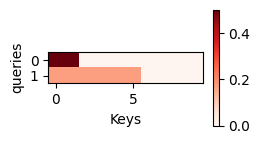

In [58]:
dltools.show_heatmaps(attention.attentionweigts.reshape((1,1,2,10)),xlabel='Keys',ylabel='queries')